# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
import pandas as pd
#from pymystem3 import Mystem
#from nltk.stem import SnowballStemmer 
from pandas.api.types import CategoricalDtype
#from collections import Counter
import matplotlib.pyplot as plt


df=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.info()
display(df.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


## Общая структура понятна, приступаем к чистке.
В первую очередь общие, очевидные обработки:

In [2]:
# удаляем полностью пустые строки
df.dropna(thresh=2,inplace=True)

# приводим столбец total_images к числовому типу
df.total_images=pd.to_numeric(df.total_images)

# приводим столбец first_day_exposition к типу datetime
df.first_day_exposition=pd.to_datetime(df.first_day_exposition,format='%Y-%m-%dT%H:%M:%S')

# вычисляем стимость 1 кв метра
df['metr_price']=df.last_price/df.total_area

# заменяем пустые значения на 0, в тех столбцах где я решил, что это возможно
#df.cityCenters_nearest=df.cityCenters_nearest.fillna(value=0)
df.parks_around3000=df.parks_around3000.fillna(value=0)
df.parks_nearest=df.parks_nearest.fillna(value=0)
df.ponds_around3000=df.ponds_around3000.fillna(value=0)
df.ponds_nearest=df.ponds_nearest.fillna(value=0)
df.airports_nearest=df.airports_nearest.fillna(value=0)

# Имеется 46 строк без данных о месте расположения - критичная информация для анализа, строки удаляем
df.drop(df[df['locality_name'].isnull()].index, inplace=True)


# вычисляем расстояние до центра, в километрах, округленное до целого
df['cityCenters_km']=round(df['cityCenters_nearest']/1000)
#df['cityCenters_km']=df['cityCenters_km'].astype('int64')

## исследуем ceiling_height

count    14490.000000
mean         2.771287
std          1.261593
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


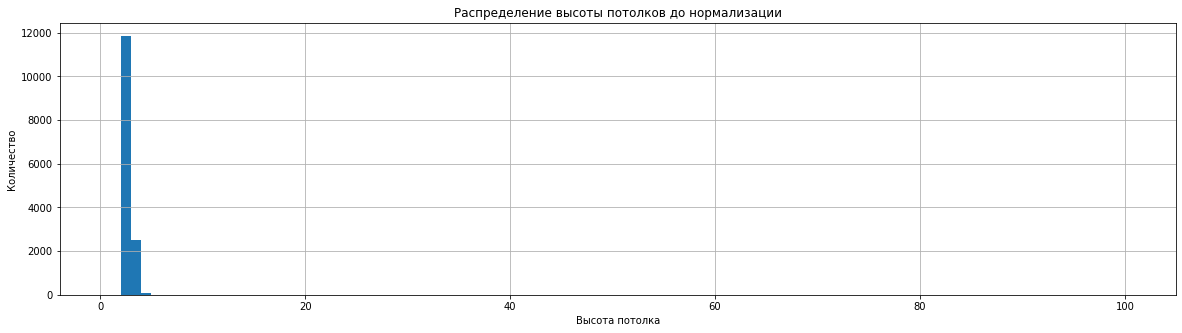

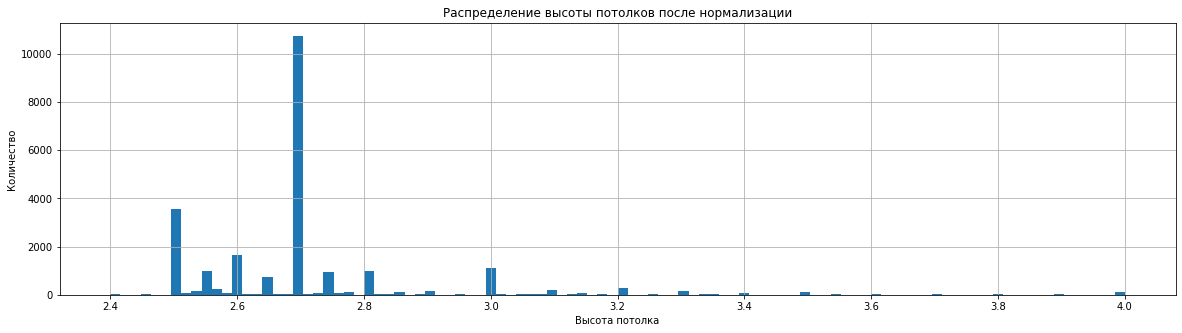

In [3]:
# Исследуем ceiling_height
print(df.ceiling_height.describe())
df.ceiling_height.hist(bins=100,figsize=(20,5))
plt.title('Распределение высоты потолков до нормализации')
plt.xlabel('Высота потолка')
plt.ylabel('Количество')
plt.show()
# заменяем пустые значения на 2.7, как среднее
df.ceiling_height=df.ceiling_height.fillna(2.7)
# приводим значения высоты потолков менее 2.4 к 2.4 и более 4 к 4 как к наиболее достоверным значениям 
df.ceiling_height=df.ceiling_height.where(df.ceiling_height>2.4,2.4)
df.ceiling_height=df.ceiling_height.where(df.ceiling_height<4,4)
df.ceiling_height.hist(bins=100,figsize=(20,5))
plt.title('Распределение высоты потолков после нормализации')
plt.xlabel('Высота потолка')
plt.ylabel('Количество')
plt.show()

## исследуем total_area

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64


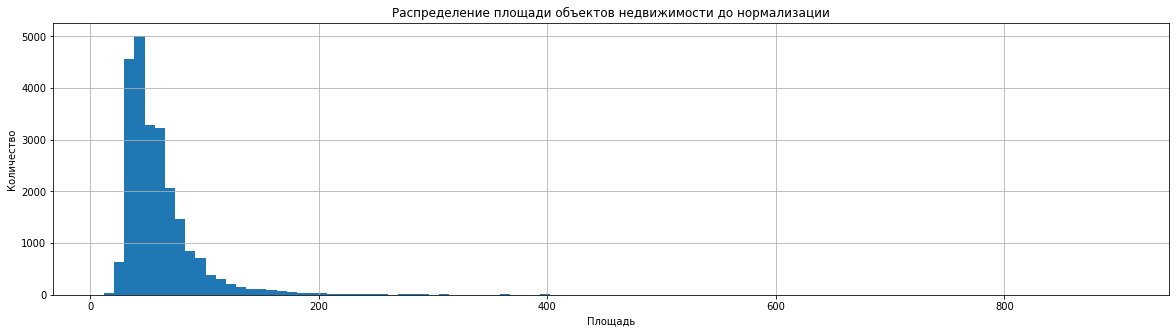

Количество объектов с площадью <30кв.м. :692
Количество объектов с площадью >150кв.м.:562
Распределение после отбрасывания хвоста


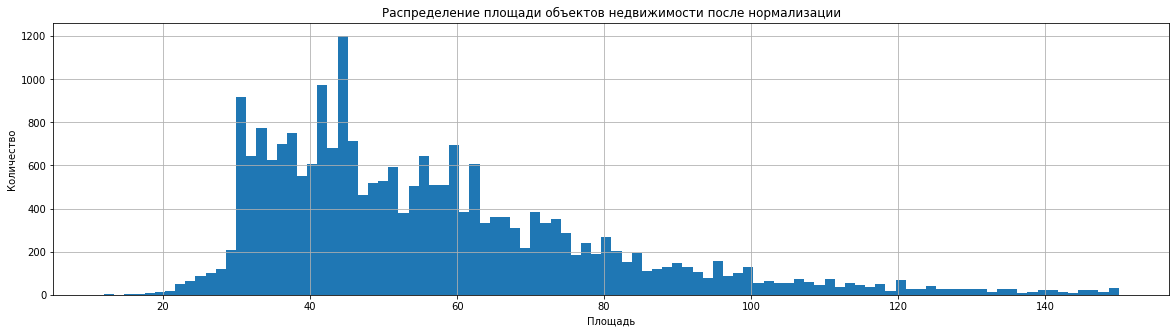

In [4]:
print(df.total_area.describe())
# средняя 60, что в рамках разумного, минимальная 12
df.total_area.hist(bins=100,figsize=(20,5))
plt.title('Распределение площади объектов недвижимости до нормализации')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()
# разумное распределение с длинным хвостом вправо.
print('Количество объектов с площадью <30кв.м. :{}'.format(df[df['total_area']<30]['total_area'].count()))
print('Количество объектов с площадью >150кв.м.:{}'.format(df[df['total_area']>150]['total_area'].count()))
# отброшу дворцы и пентхаусы >150. Оставлю левый хвост, т.к. квартиры площадью 20кв.м. сам видел, может сейчас и 12 считается.
df.drop(df[df.total_area>150].index, inplace=True)
print('Распределение после отбрасывания хвоста')
df.total_area.hist(bins=100,figsize=(20,5))
plt.title('Распределение площади объектов недвижимости после нормализации')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()

## Исследование last_price

count        23088.00000
mean       5695669.01810
std        4528743.62069
min          12190.00000
25%        3400000.00000
50%        4590000.00000
75%        6500000.00000
max      124000000.00000
Name: last_price, dtype: object


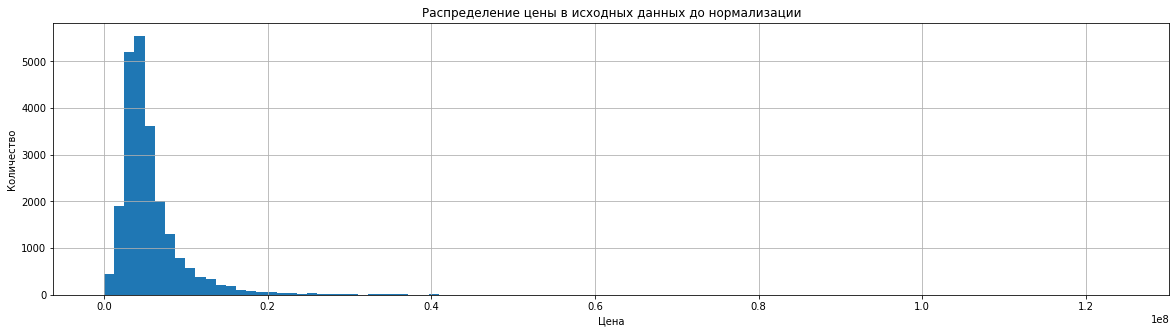

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,cityCenters_km
8793,7,12190.0,109.0,2019-03-20,2,2.75,25.0,32.0,25,NaN,...,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,0.0,8.0,111.834862,9.0


Количество объектов с ценой >20млн.: 333


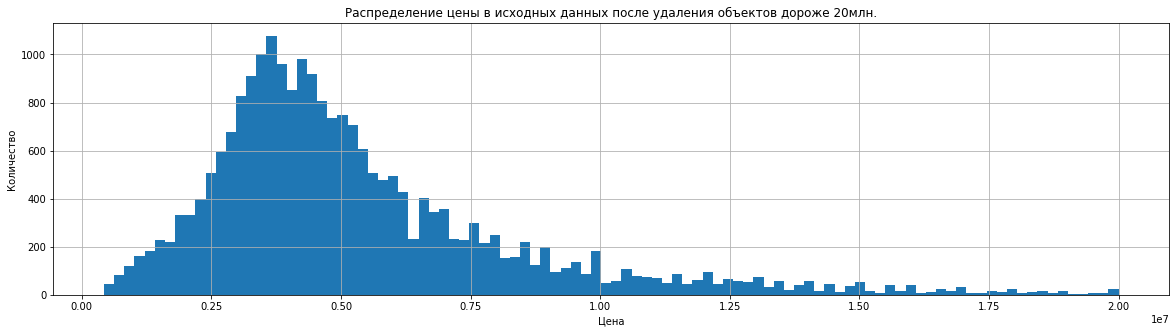

In [5]:
# Исследование last_price
print(df.last_price.describe().apply("{0:.5f}".format))
# минимальное и максимальное значение неправдоподобны
df['last_price'].hist(bins=100,figsize=(20,5))
plt.title('Распределение цены в исходных данных до нормализации')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()
# всего одно значение с ценой менее 400 тыс, посмотрим на строку
display(df[df.last_price<400000])
# данные выглядят странно, общая площадь 109, 2 комнаты но жилая 32, кухня 40.
# считаю эту строку полностью недостоверной, и удалю из данных
df.drop(df[df.index == 8793].index, inplace=True)
# практически нормальное распределение с длинным хвостом вправо.
print('Количество объектов с ценой >20млн.: {}'.format(df[df['last_price']>20000000]['last_price'].count()))
# 334 из более 20тыс объявлений дают хвост вправо. Удаляю.
df.drop(df[df['last_price'] >20000000].index, inplace=True)
df['last_price'].hist(bins=100,figsize=(20,5))
plt.title('Распределение цены в исходных данных после удаления объектов дороже 20млн.')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()


## исследуем число комнат

count    22754.000000
mean         1.985277
std          0.943070
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64
Число объектов с числом комнат=0 :196


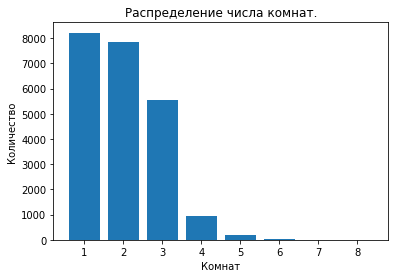

Число объектов с числом комнат>=6 :29


In [6]:
# исследуем число комнат
print(df.rooms.describe())
print('Число объектов с числом комнат=0 :{}'.format(df[df['rooms']==0]['rooms'].count()))
# у 196 объектов число комнат=0, поскольку этот параметр используется в анализе, то заменим 0 на 1
df.replace({'rooms': {0 : 1}},inplace=True)
rc=df.groupby('rooms')['rooms'].count()
plt.bar(rc.index,height=rc)
plt.title('Распределение числа комнат.')
plt.xlabel('Комнат')
plt.ylabel('Количество')
plt.show()
print('Число объектов с числом комнат>=6 :{}'.format(df[df['rooms']>=6]['rooms'].count()))
# всего 29 объектов с числом комнат от 6 и выше. Пусть остаются.

## дополнительная проверка адекватности данных по параметру "цена квадратного метра"

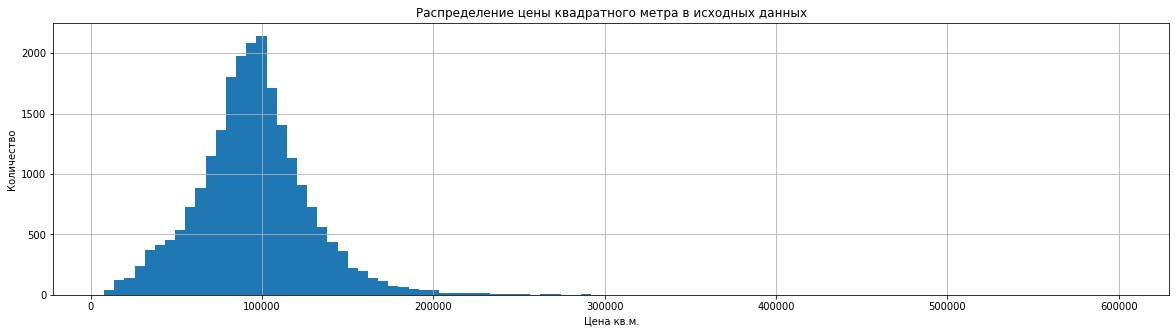

count     22754.000000
mean      94939.834030
std       32890.993760
min        7962.962963
25%       75825.477840
50%       94131.543922
75%      112294.388398
max      600000.000000
Name: metr_price, dtype: float64
Количество объявлений с ценой квадратного метра  более 200тыс: 140


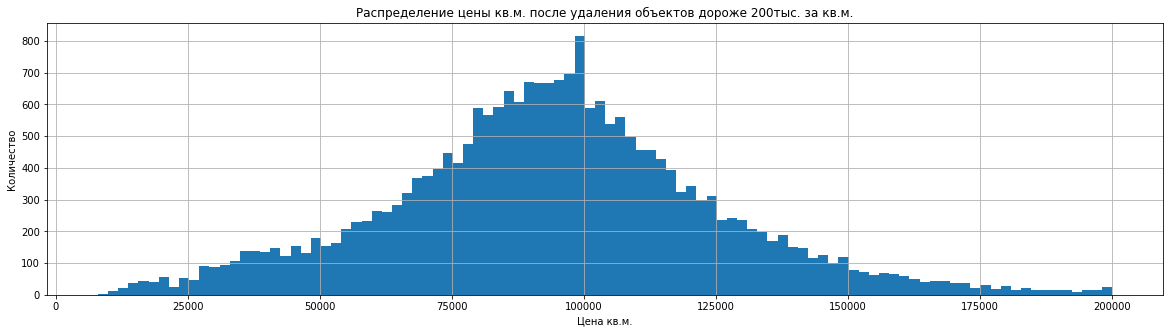

In [7]:
# дополнительная проверка адекватности данных по параметру "цена квадратного метра"
df.metr_price.hist(bins=100,figsize=(20,5))
plt.title('Распределение цены квадратного метра в исходных данных')
plt.xlabel('Цена кв.м.')
plt.ylabel('Количество')
plt.show()
print(df.metr_price.describe())
print('Количество объявлений с ценой квадратного метра  более 200тыс: {}'.format(df[df.metr_price>200000].metr_price.count()))
# у нас есть 140 объявлений с выходящей за рамки разумного ценой квадратного метра. Я их удалю.
df.drop(df[df['metr_price'] >200000].index, inplace=True)
df.metr_price.hist(bins=100,figsize=(20,5))
plt.title('Распределение цены кв.м. после удаления объектов дороже 200тыс. за кв.м.')
plt.xlabel('Цена кв.м.')
plt.ylabel('Количество')
plt.show()


## анализируем время продажи квартир

count    19702.000000
mean       176.860623
std        215.837447
min          1.000000
25%         44.000000
50%         93.000000
75%        225.000000
max       1580.000000
Name: days_exposition, dtype: float64
Среднее время продажи: 176.86062328697594
Медианное время продажи: 93.0
2912


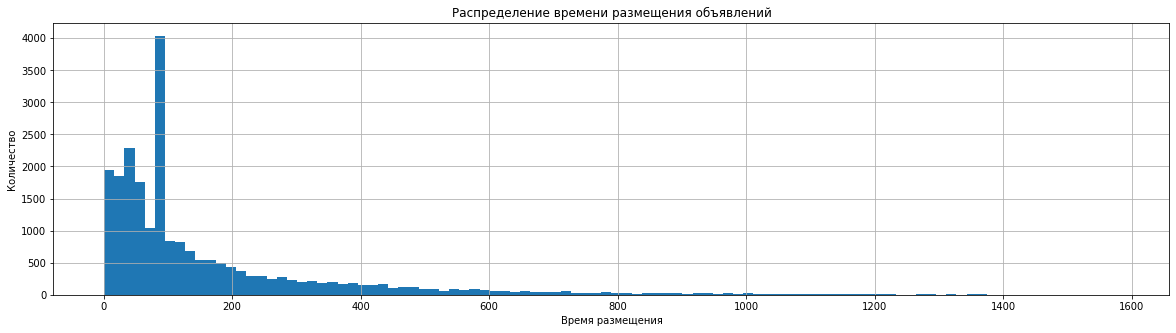

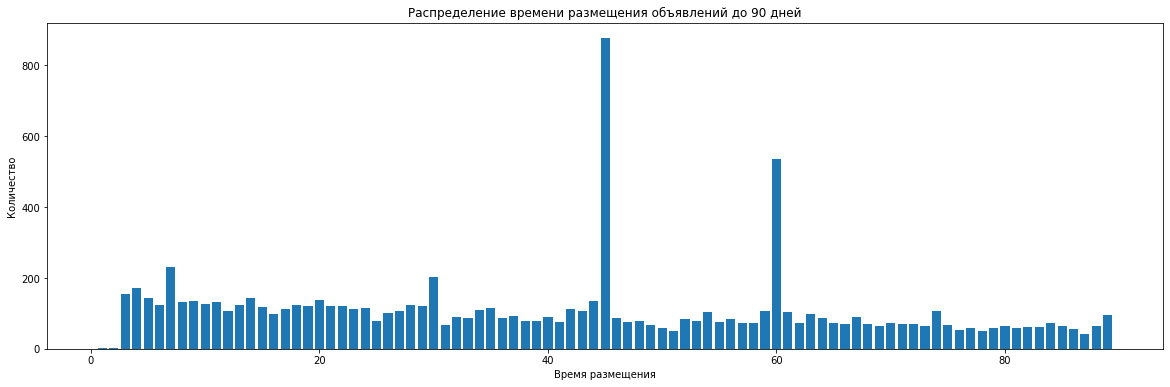

In [8]:
# анализируем время продажи квартир

print(df.days_exposition.describe())
print('Среднее время продажи: {}'.format(df.days_exposition.mean()))
print('Медианное время продажи: {}'.format(df.days_exposition.median()))
print(len(df[df.days_exposition.isnull()]))
# имеем 2912 объявлений с пустым значением, это слишком много что-бы удалять, заменю на медианное
df.days_exposition=df.days_exposition.fillna(value=93)
df.days_exposition.hist(bins=100,figsize=(20,5))
plt.title('Распределение времени размещения объявлений')
plt.xlabel('Время размещения')
plt.ylabel('Количество')
plt.show()
# имеется 245 объявлений со сроком размещения >1000 дней, это однозначно забытые и не снятые объявления, но удалять их не буду
# выброс на 93 днях это результат замены Null на 93
# посмотрим значения до 90
rc=df[df.days_exposition<90].groupby('days_exposition')['days_exposition'].count()
fig, ax = plt.subplots()
ax.bar(rc.index,height=rc)
fig.set_figwidth(20)  
fig.set_figheight(6)
plt.title('Распределение времени размещения объявлений до 90 дней')
plt.xlabel('Время размещения')
plt.ylabel('Количество')
plt.show()
# имеется существенный пик на времени продажи в 45 и 60 дней. Объяснить это я не могу, просто наблюдение.
# Значит мы можем сказать, что "нормальным" временем продажи можно считать от 45 до 60 дней.
# Все что больше медианного 93 можно считать долго, все что меньше 40 - быстро.


## распределение объявлений по датам

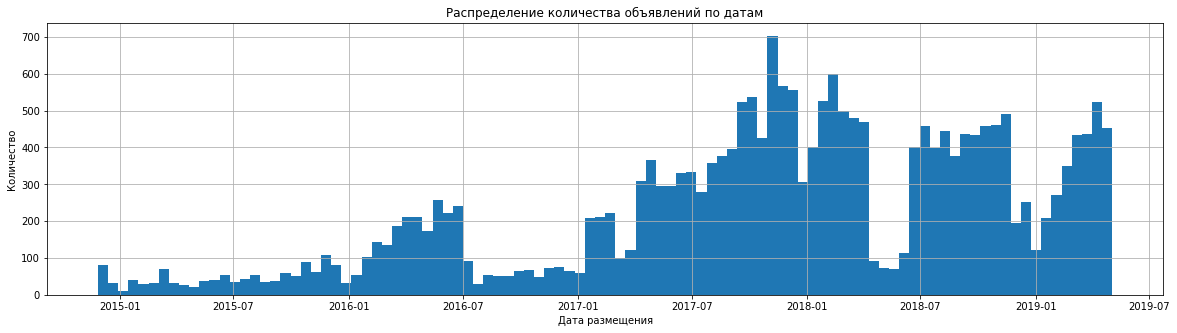

In [9]:
# просто из любопытсва, хочу посмотреть как распределенны объявления по датам:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
df.first_day_exposition.hist(bins=100,figsize=(20,5))
plt.title('Распределение количества объявлений по датам')
plt.xlabel('Дата размещения')
plt.ylabel('Количество')
plt.show()

### Вывод

1. По результатам изучение данных имеем:

### total_images
- значение от от 0 до 50, пустых нет, в анализе не используется - оставляем как есть

### last_price          
- значения от 12млн до 124 млн, пустых нет. Цена менее 400тыс. только у одного объекта. После анализа данных из других столбцов этой строки, принято решение ее удалить. Цена более 20млн. у 334 из более 20тыс объявлений. Для нормализации принято решение удалить эти объекты.

### total_area           
- средняя 60, что в рамках разумного, минимальная 12. Отброшу дворцы и пентхаусы с площадью>150. Оставлю левый хвост, т.к. квартиры площадью 20кв.м. сам видел, может сейчас и 12 считается

### first_day_exposition 
- есть одно пустое значение, строка содержащая это значение будет удаленна

### rooms                
- 196 объектов у которых число комнат=0, поскольку этот параметр используется в анализе, то заменим 0 на 1

### ceiling_height      
- значение от 1 до 100 медиана 2,7, есть пустые. Пустые заменяем на 2.7, значения менее 2,4 считаем неверными и заменяем на  2.4, значения более 4 считаем неверными и заменяем на 4 

### floors_total         
- есть пустые значение, в анализе не используется - оставляем как есть

### living_area          
- есть пустые значение, в анализе не используется - оставляем как есть

### floor                
- пустых нет, значения от 1 до 33

### is_apartment         
- есть пустые значение, в анализе не используется - оставляем как есть

### studio               
- не анализировалось   

### open_plan            
- не анализировалось

### kitchen_area         
- есть пустые значения в анализе не используется - оставляем как есть

### balcony              
- есть пустые значения в анализе не используется - оставляем как есть

### locality_name        
- 46 строк без данных о месте расположения - критичная информация для анализа, строки удаляем

### airports_nearest     
- есть пустые значения, заменяем 0

### cityCenters_nearest  
- есть пустые значения, заменяем 0, т.к. при отсутствии адреса нет возможности вычислить самому

### parks_around3000     
- есть пустые значения, заменяем 0

### parks_nearest        
- есть пустые значения, заменяем 0

### ponds_around3000     
- есть пустые значения, заменяем 0

### ponds_nearest        
- есть пустые значения, заменяем 0

### days_exposition      
- имеем 2912 объявлений с пустым значением, это слишком много что-бы удалять, заменю на медианное. Кроме того, 245 объявлений со сроком размещения >1000 дней, это однозначно забытые и не снятые объявления, но удалять их не буду. На гистограмме можно увидеть существенный пик на времени продажи в 45 и 60 дней, видимо это результат работы автоматического снятия объявлений с показа. Значит мы можем сказать, что "нормальным" временем продажи можно считать от 45 до 60 дней. Все что больше медианного 93 можно считать долго, все что меньше 40 - быстро.

## Предобработка данных

Я провел предобработки, замены NULL и расчеты во второй сверху ячейке. Я сделал это что-бы при дальнейшем анализе конкретных значений работать с достоверными данными, без пустых значений и использовать расчетные показатели вроде цены квадратного метра.

## Расчёты и добавление результатов в таблицу

Выполненны во второй сверху ячейке

## Исследовательский анализ данных

## анализ зависимости цены от разных параметров
Сейчас я хочу провести анализ зависимости цены от разных параметров. В нашей таблице 363 населенных пункта. параметры для разных населенных пунктов будут сильно различаться. Подавляющее число объявлений относиться к Санкт-Петербургу, поэтому, для того чтобы снизить разброс при анализе зависимостей, я возьму данные только по Санкт-Петербургу.

In [10]:
# здесь мы смотрим сколько объявлений в разных еаселенных пунктах
print(df.groupby('locality_name')['locality_name'].count().sort_values(ascending=False))
testdf=df[df.locality_name=='Санкт-Петербург']

locality_name
Санкт-Петербург          14728
посёлок Мурино             522
посёлок Шушары             440
Всеволожск                 396
Пушкин                     356
                         ...  
деревня Чудской Бор          1
деревня Хапо-Ое              1
деревня Трубников Бор        1
деревня Тойворово            1
поселок Жилпосёлок           1
Name: locality_name, Length: 363, dtype: int64


### зависимость цена/площадь

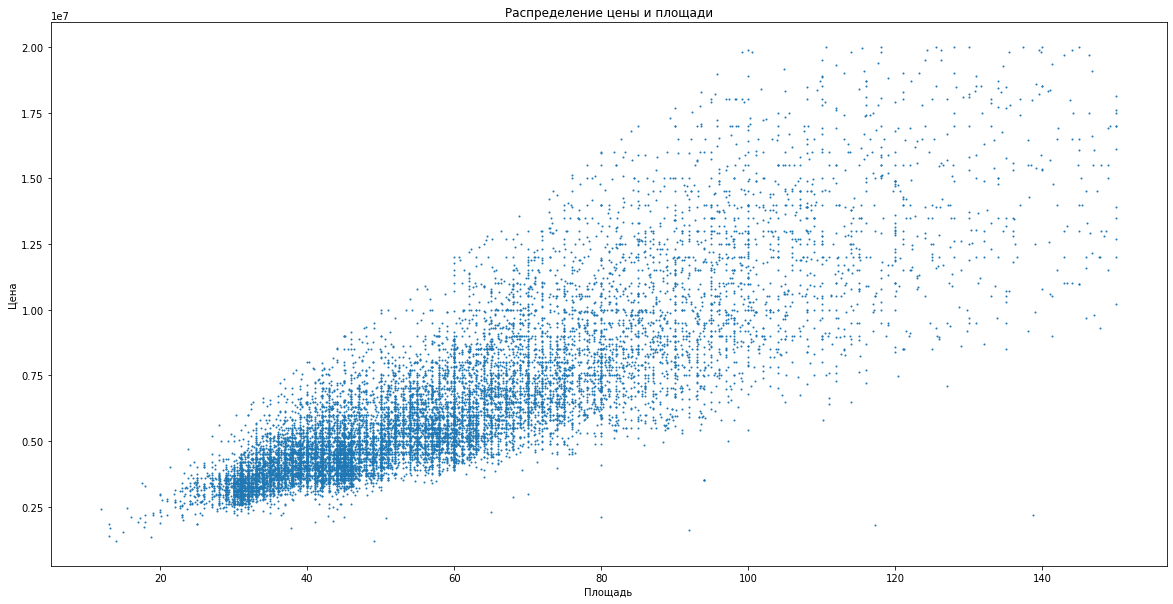

Коэффициент корреляции : 0.8411370658904123


In [11]:
# зависимость цена/площадь
testdf.plot(x='total_area',y='last_price',kind='scatter',figsize=(20,10),s=1)
plt.title('Распределение цены и площади')
plt.xlabel('Площадь')
plt.ylabel('Цена')
plt.show()
print('Коэффициент корреляции : {}'.format(testdf.last_price.corr(testdf.total_area)))

Очевидно, что цена прямо зависит от площади, но не так жестко как могло бы показаться. Массовый сегмент, площадь до 80кв.м. цена до 5млн., достаточно плотно расположенны значения, но чем больше цена или площадь, тем больше разброс. Квартиру в 140 кв.м. можно купить от 10млн до 20млн. 

### цена/число комнат

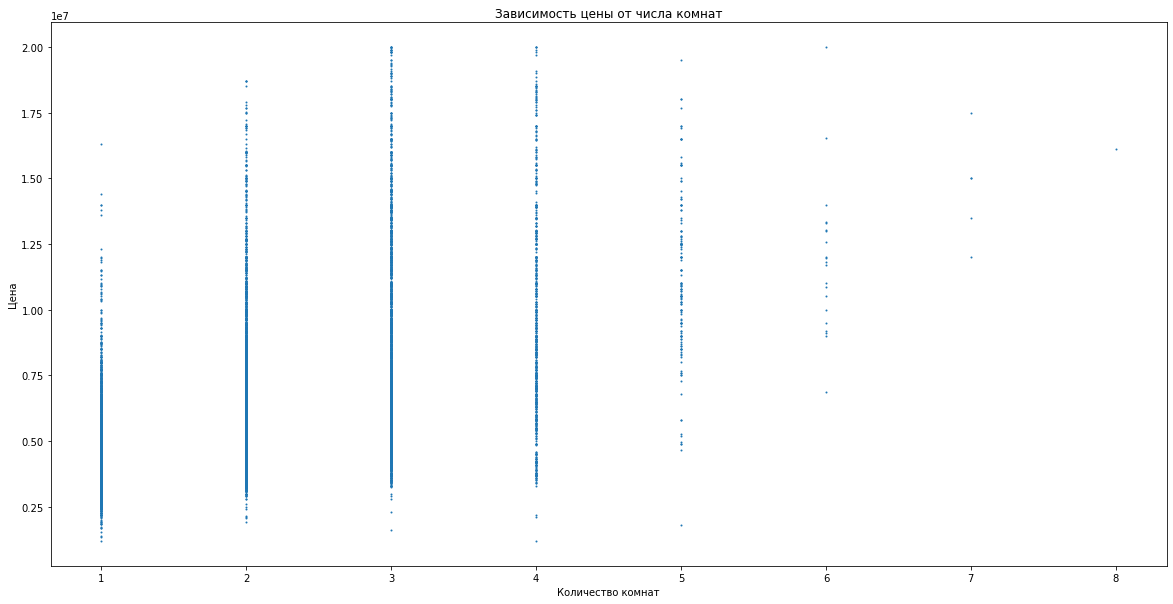

Коэффициент корреляции : 0.546647209600215


In [12]:
# цена/число комнат
testdf.plot(x='rooms',y='last_price',kind='scatter',figsize=(20,10),s=1)
plt.title('Зависимость цены от числа комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.show()
print('Коэффициент корреляции : {}'.format(testdf.last_price.corr(testdf.rooms)))


Крайне неудачный параметр для анализа, 1 комната это и студия 20кв.м. и аппартаменты 140кв.м. свободной планировки. Вооьщем можно сказать что зависимости цены от количества комнат практически нет.
Посмотрим для цены кв.м.

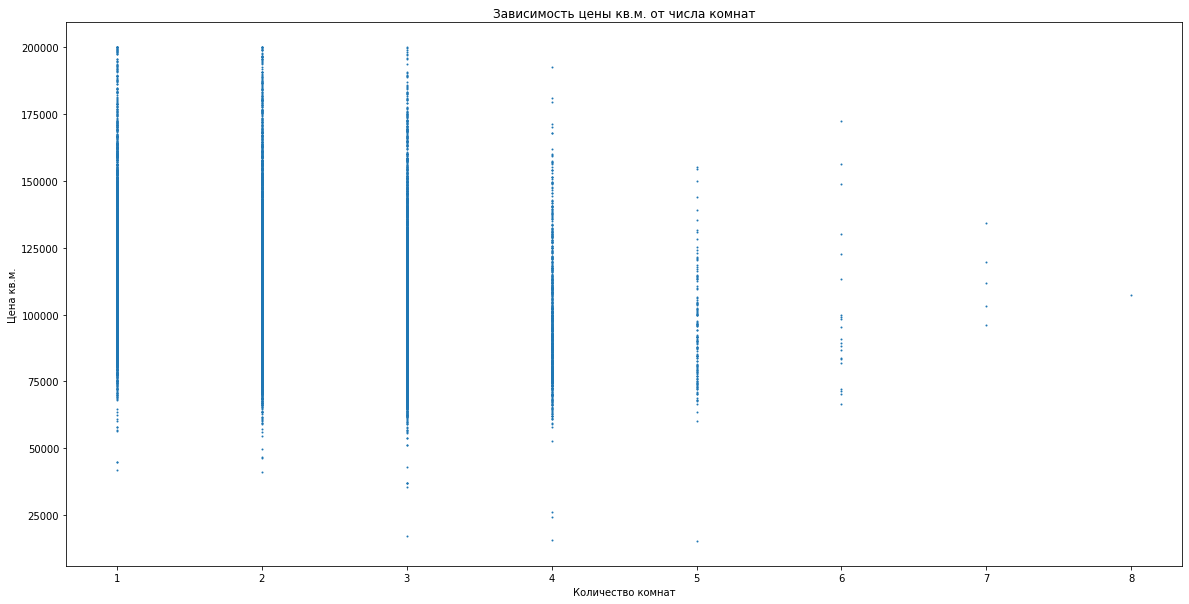

Коэффициент корреляции : -0.22807098594530123


In [13]:
# стоимости кв.м./число комнат
testdf.plot(x='rooms',y='metr_price',kind='scatter',figsize=(20,10),s=1)
plt.title('Зависимость цены кв.м. от числа комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена кв.м.')
plt.show()
print('Коэффициент корреляции : {}'.format(testdf.metr_price.corr(testdf.rooms)))

А для стоимости квадратного метра вообще обратная зависимоть. Оптом дешевле.

### цена/удаленность от центра

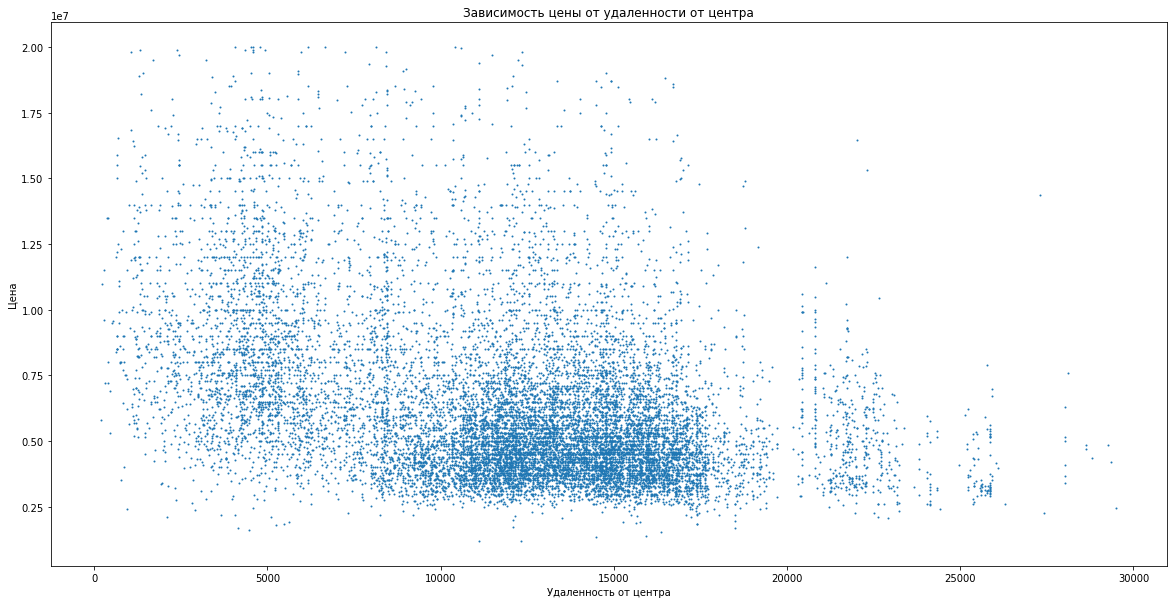

Коэффициент корреляции : -0.38715659395324825


In [14]:
# цена/удаленность от центра
testdf.plot(x='cityCenters_nearest',y='last_price',kind='scatter',figsize=(20,10),s=1)
plt.title('Зависимость цены от удаленности от центра')
plt.xlabel('Удаленность от центра')
plt.ylabel('Цена')
plt.show()
print('Коэффициент корреляции : {}'.format(testdf.last_price.corr(testdf.cityCenters_nearest)))

Слабая обратная зависимость. Понятно, что чем дальше от центра, тем в целом дешевле, но неудачный параметр, информативность низкая.
Посмотрим то-же самое с ценой кв.м.

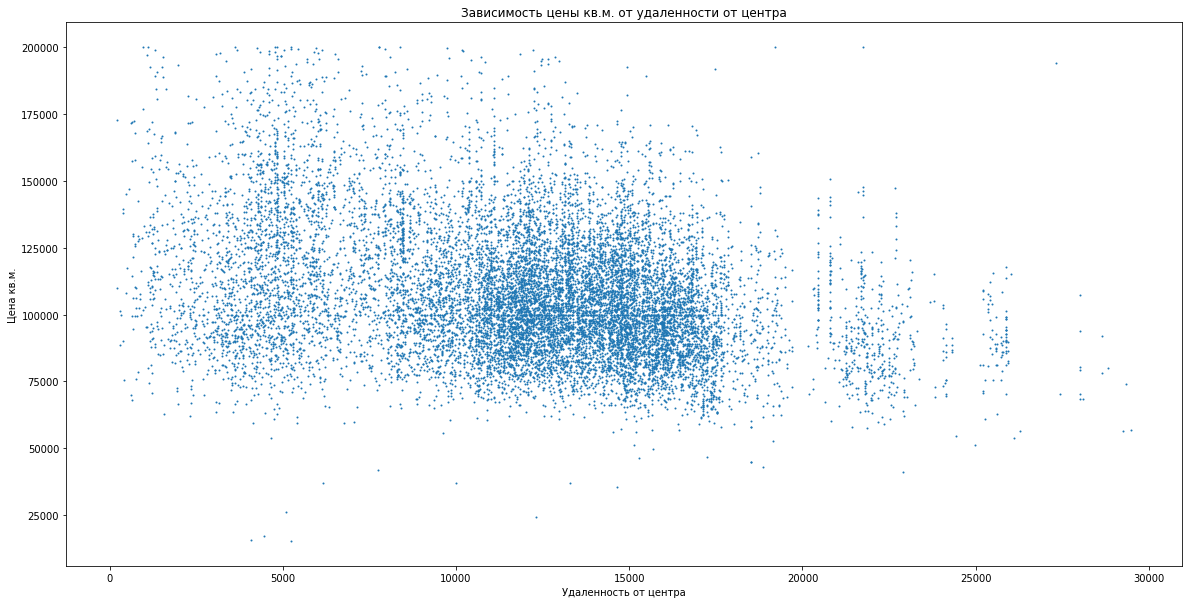

Коэффициент корреляции : -0.3111996209685917


In [15]:
testdf.plot(x='cityCenters_nearest',y='metr_price',kind='scatter',figsize=(20,10),s=1)
plt.title('Зависимость цены кв.м. от удаленности от центра')
plt.xlabel('Удаленность от центра')
plt.ylabel('Цена кв.м.')
plt.show()
print('Коэффициент корреляции : {}'.format(testdf.metr_price.corr(testdf.cityCenters_nearest)))

и зависимоть цены кв.м. от удаленности от центра доаольно слабая.

### цена/этаж

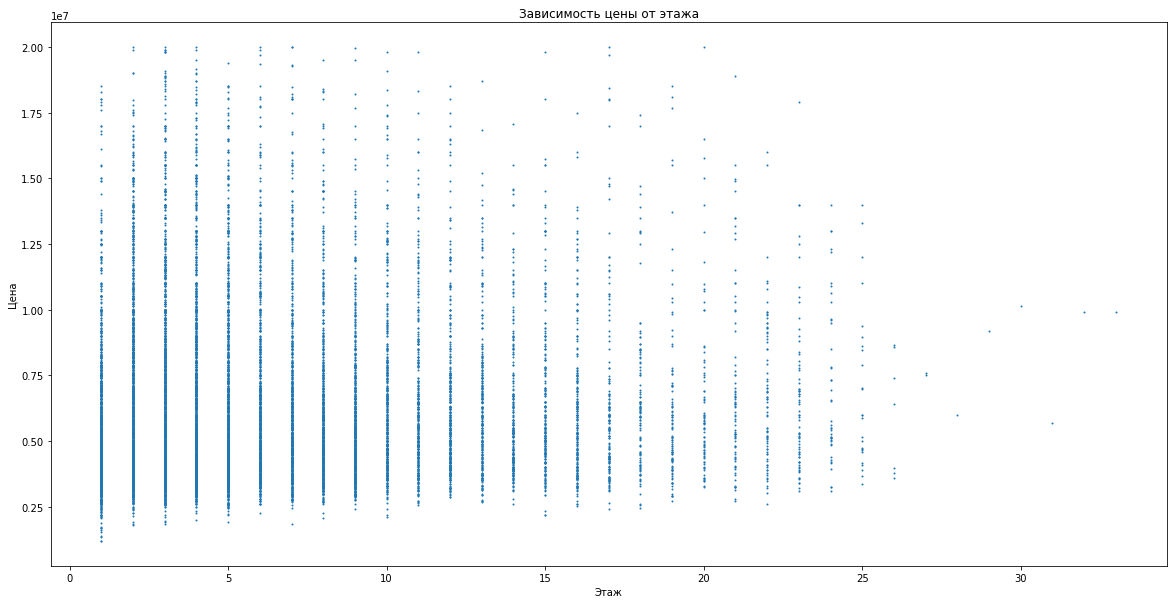

Коэффициент корреляции : 0.037996083978683697


In [16]:
# цена/этаж
testdf.plot(x='floor',y='last_price',kind='scatter',figsize=(20,10),s=1)
plt.title('Зависимость цены от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена')
plt.show()
print('Коэффициент корреляции : {}'.format(testdf.last_price.corr(testdf.floor)))

Вообще никакой зависимости. Опять неудачное сочетание параметров. Что-бы выяснить зависимость от этажности нужно сравнивать одинаковые по площади квартиры.
Сделаем то-же самое но состоимостью кв.м.

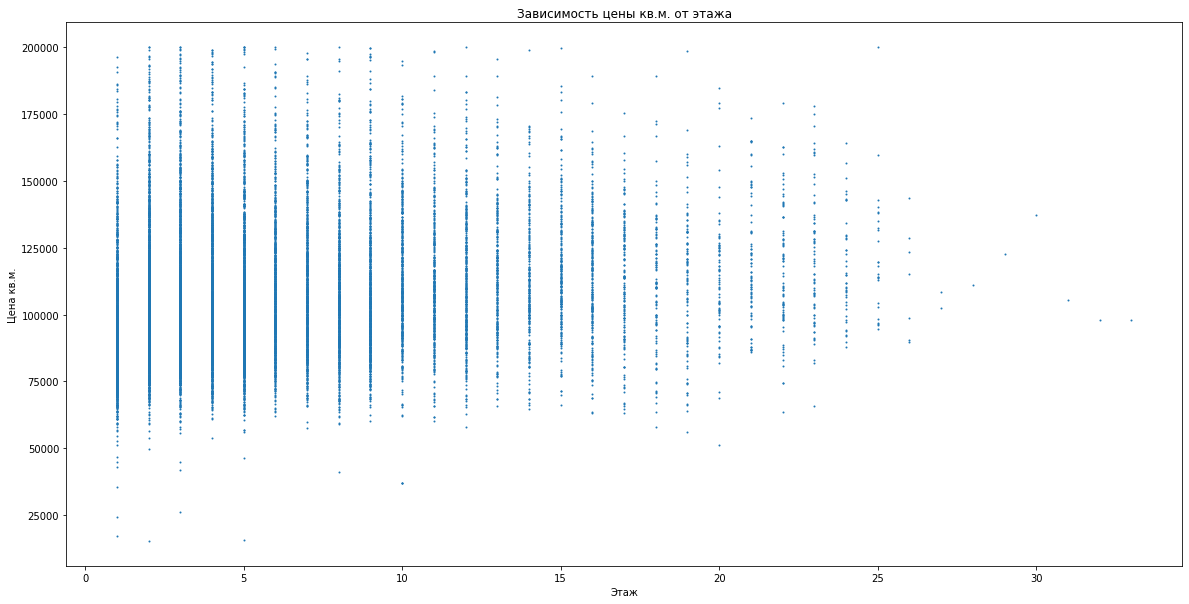

Коэффициент корреляции : 0.1567886485856121


In [17]:
testdf.plot(x='floor',y='metr_price',kind='scatter',figsize=(20,10),s=1)
plt.title('Зависимость цены кв.м. от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена кв.м.')
plt.show()
print('Коэффициент корреляции : {}'.format(testdf.metr_price.corr(testdf.floor)))

Зависимость цены квадратного метра от этажности уже намного выше, но и в этом случае этажность не является критичным параметром.


## Анализ зависимости цены первый/последний этаж


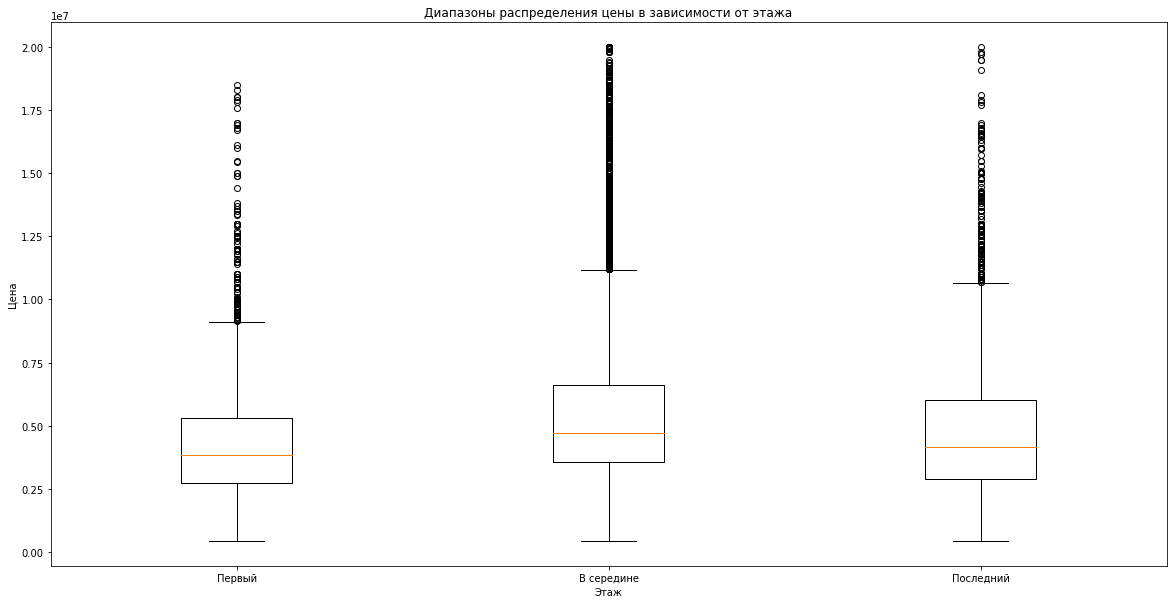

In [18]:
# Проанализируем как зависит цена от того на каом этаже, первом/последнем/в середине расположенна квартира
# введем столбец, в котором будем хранить признак 1 - последний этаж, 0 - не последний
df['top_floor']=0
# оформлю вычисление признака процедурой. 
# Вариант df['top_floor']=df.apply(lambda s: 1 if df.floo=df.total_floors else 0) у меня не заработал, незнаю почему
def TF(row):
    if row['floor']==row['floors_total']:
        return(1)
    else:
        return(0)

df['top_floor']=df.apply(TF,axis=1)   
import numpy as np
# подготовим данные
d1=df[df.floor==1]['last_price']                       # выборка 1 этаж
d2=df[(df.floor!=1) & (df.top_floor==0)]['last_price'] # выборка средние этажи
d3=df[df.top_floor==1]['last_price']                   # выборка последний этаж
data=np.array([d1,d2,d3],dtype=object)                 # собираем в один блок, без dtype=object ругается
# рисуем
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.boxplot(data,labels=['Первый','В середине','Последний'])
plt.title('Диапазоны распределения цены в зависимости от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена')
plt.show()


Средние этажи статистически заментно дороже, чем первый и последний.

## Общая матрица параметров
Построим матрицу взаимозависимости параметров:

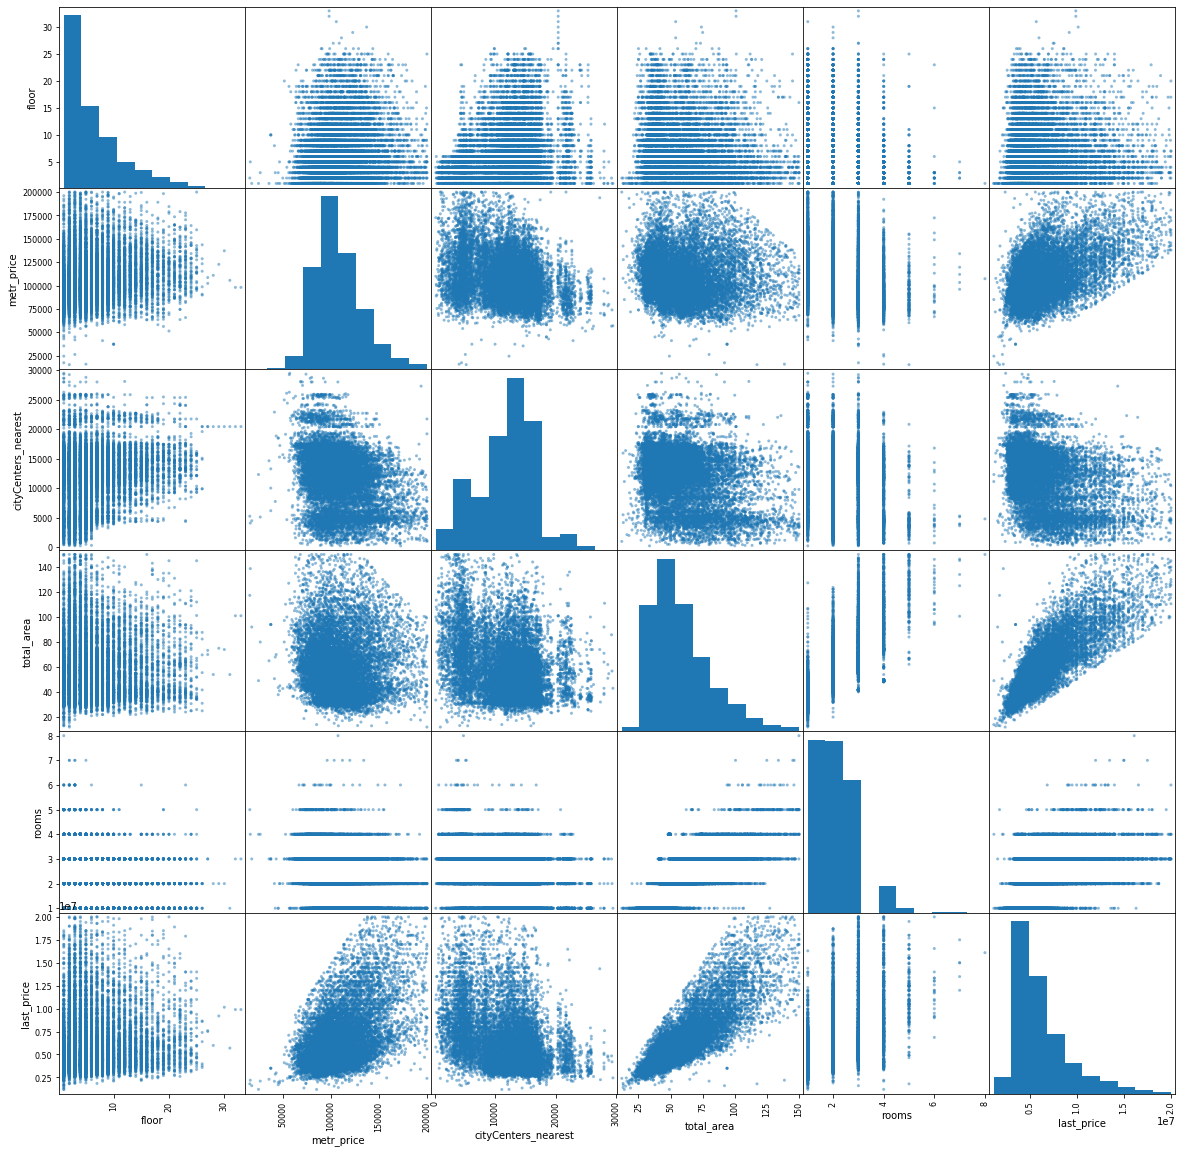

In [19]:
tdf=testdf.loc[:,['floor','metr_price','cityCenters_nearest','total_area','rooms','last_price']]
pd.plotting.scatter_matrix(tdf, figsize=(20,20))
plt.show()

Как и ожидалось, четкие зависимости видны между ценой и общей площадью, остальные параметры просто описывают диапазон значений.

## Есть ли взаимосвязь цены с днем недели, месяцем, годом размещения

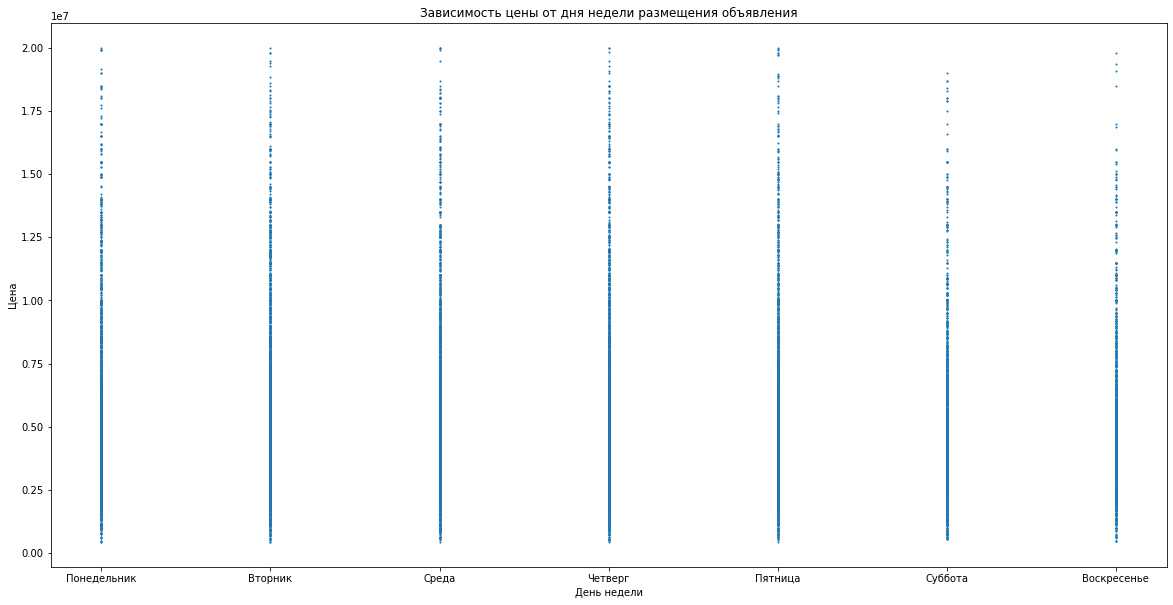

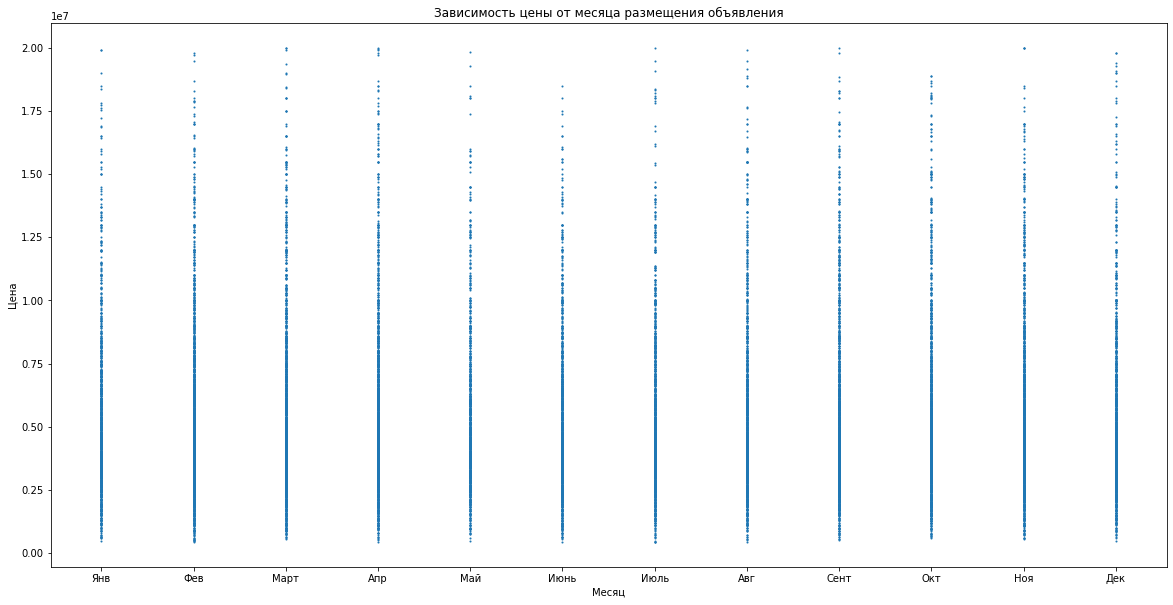

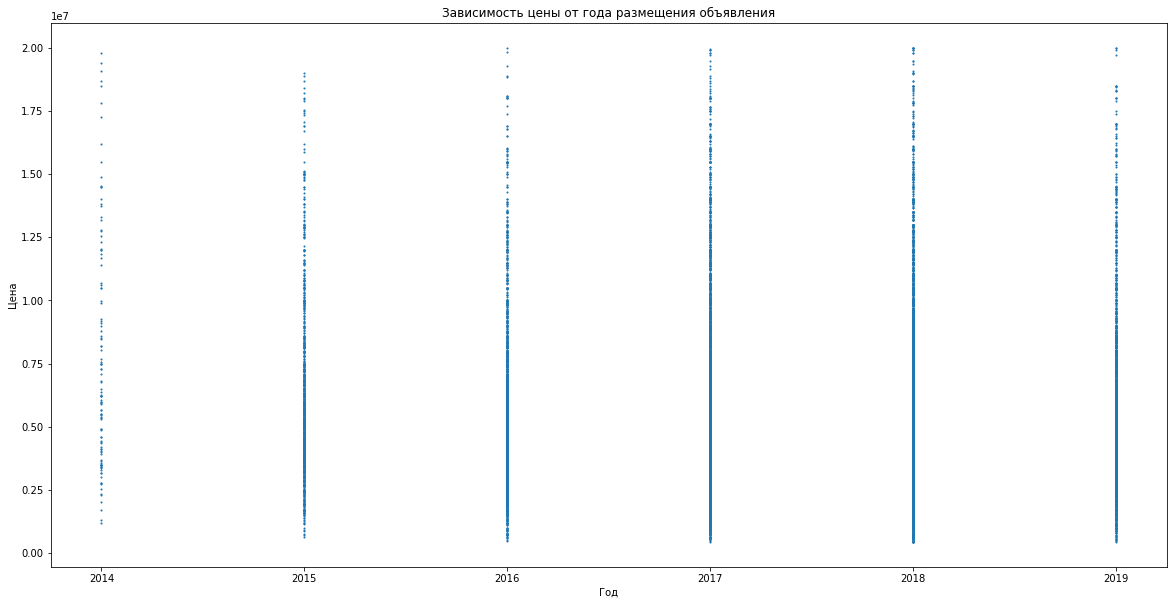

In [20]:
# Есть ли взаимосвязь цены с днем недели, месяцем, годом размещения
# Эту зависимость мы будем смотреть на полном наборе данных, а не только Санкт-Петербург
# выделяем части даты, по которым будет анализ
df['week_day_exp']=df.first_day_exposition.dt.weekday
df['month_exp']=df.first_day_exposition.dt.month
df['year_exp']=df.first_day_exposition.dt.year


df.plot(x='week_day_exp',y='last_price',kind='scatter',figsize=(20,10),s=1.1) 
my_position=([0,1,2,3,4,5,6])
my_label=(['Понедельник','Вторник','Среда','Четверг','Пятница','Суббота','Воскресенье'])
plt.xticks(my_position, my_label)
plt.title('Зависимость цены от дня недели размещения объявления')
plt.xlabel('День недели')
plt.ylabel('Цена')
plt.show()

df.plot(x='month_exp',y='last_price',kind='scatter',figsize=(20,10),s=1.1)
my_position=([1,2,3,4,5,6,7,8,9,10,11,12])
my_label=(['Янв','Фев','Март','Апр','Май','Июнь','Июль','Авг','Сент','Окт','Ноя','Дек'])
plt.xticks(my_position, my_label)
plt.title('Зависимость цены от месяца размещения объявления')
plt.xlabel('Месяц')
plt.ylabel('Цена')
plt.show()

df.plot(x='year_exp',y='last_price',kind='scatter',figsize=(20,10),s=1.1)
plt.title('Зависимость цены от года размещения объявления')
plt.xlabel('Год')
plt.ylabel('Цена')
plt.show()


Как и можно было предположить, никакой зависимости цены от дня недели, месяца и года нет

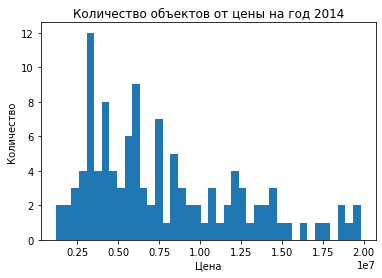

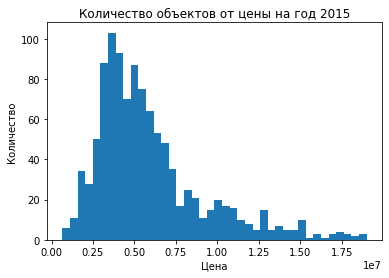

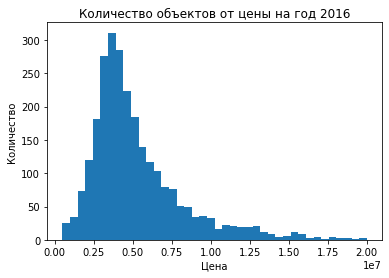

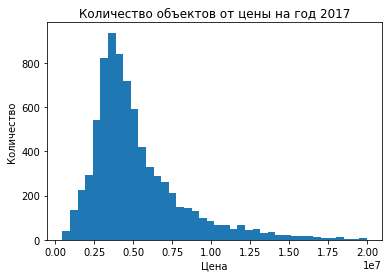

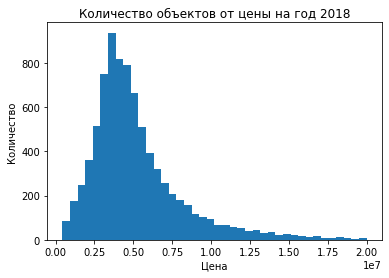

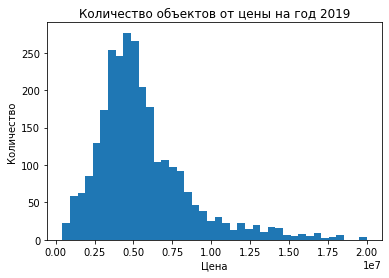

In [21]:
years=df.groupby('year_exp')['last_price'].count()
for y in years.index:
    plt.hist(df[df.year_exp==y]['last_price'],bins=40)
    plt.title('Количество объектов от цены на год {}'.format(y))
    plt.xlabel('Цена')
    plt.ylabel('Количество')
    plt.show()

В 2014 году мало объявлений, график некрасивый. А для остальных годов распределение цены практически одинаковое, с учетом масштаба.

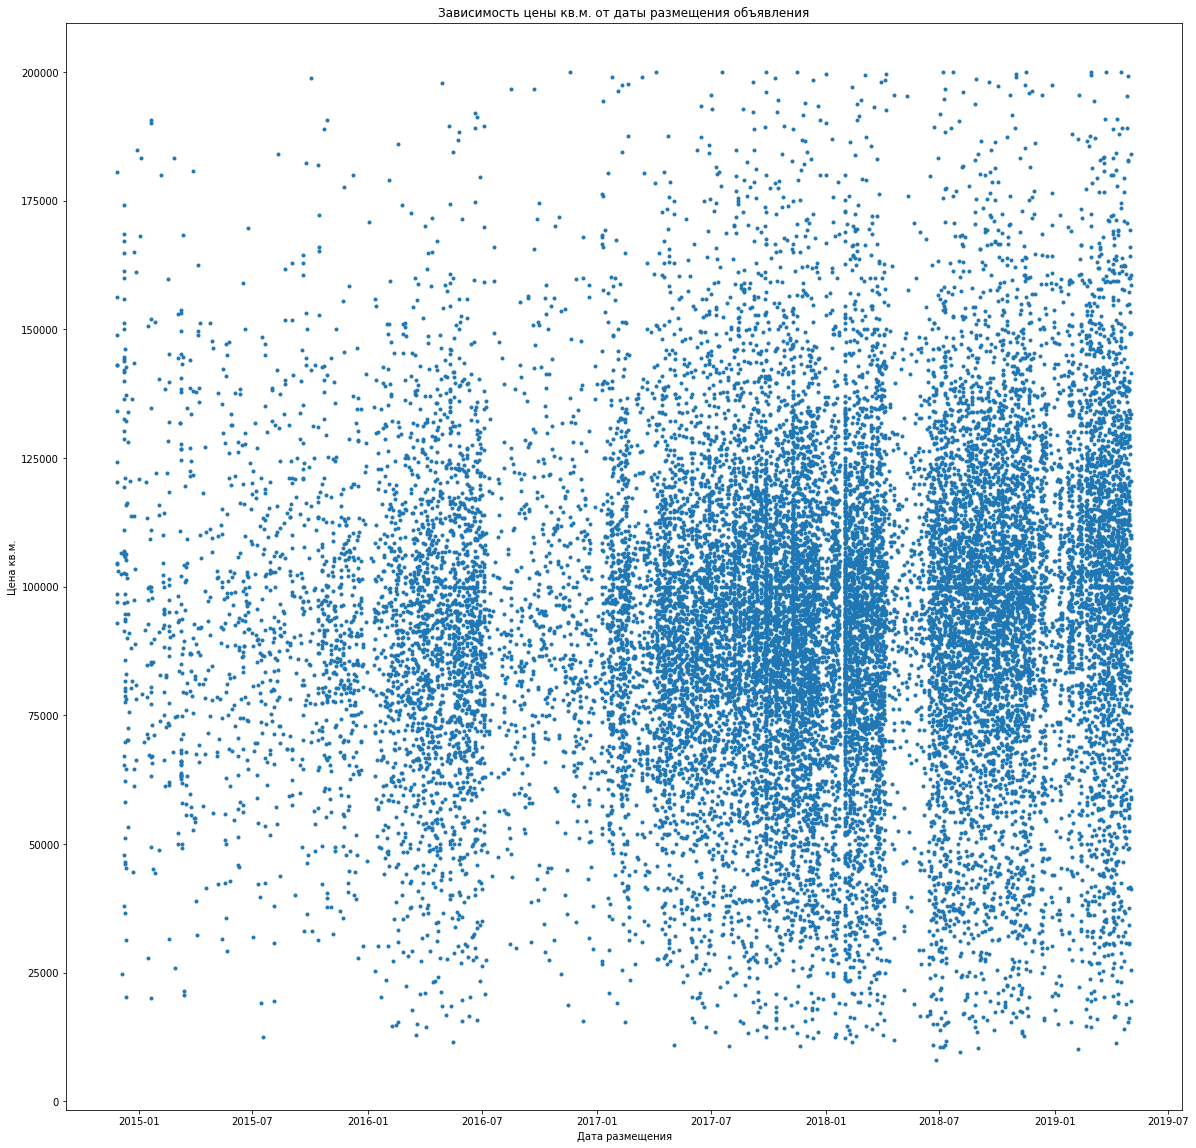

In [22]:
# Посмотрим, как менялось распределение цены квадратного метра за все время наблюдения:
fig, ax = plt.subplots()
ax.plot_date(x=df.first_day_exposition,y=df.metr_price,xdate=True,fmt='.')
fig.set_figwidth(20)
fig.set_figheight(20)
plt.title('Зависимость цены кв.м. от даты размещения объявления')
plt.xlabel('Дата размещения')
plt.ylabel('Цена кв.м.')
plt.show()

Есть некоторое уплотнение вокруг среднего, но разброс все-равно большой.

## Выделить 10 нас.пунктов с наибольшим число объявлений и провести анализ.

In [23]:
# выбрать 10 нас.пунктов с наибольшим числом объектов. Выч ср.ст.кв.м. Указать нас.пункты с макс и мин. ст
# делаем выборку ТОП 10 населенных пунктов по числу объявлений 
top10=df.groupby('locality_name')['locality_name'].count().sort_values(ascending=False).head(10)
# создаем вспомогательный датафрейм
dftop10=pd.DataFrame(top10)
# вставляем столбцы, в которые будем сохранять значения
dftop10['kv_m_mean']=''
dftop10['min_st']=''
dftop10['max_st']=''
# вычисляем необходимые параметры для каждой строки из датафрейма с ТОП 10 
for row in dftop10.index:
    dftop10.loc[dftop10.index==row,['min_st']]=df[df.locality_name==row]['last_price'].min()
    dftop10.loc[dftop10.index==row,['max_st']]=df[df.locality_name==row]['last_price'].max()
    dftop10.loc[dftop10.index==row,['kv_m_mean']]=df[df.locality_name==row]['metr_price'].mean()
# переименовываем столбцы
dftop10.columns=['Объектов','Ср. стоимость кв.м.','Мин. стоимость объекта','Макс. стоимость объекта']
# отображаем
display(dftop10.sort_values(by='Ср. стоимость кв.м.',ascending=False))


,Объектов,Ср. стоимость кв.м.,Мин. стоимость объекта,Макс. стоимость объекта
locality_name,,,,
Санкт-Петербург,14728,107705,1190000,20000000
Пушкин,356,101859,1990000,16912000
деревня Кудрово,299,92473.5,1800000,13000000
посёлок Парголово,326,90332.3,1400000,9140000
посёлок Мурино,522,85752.2,1730000,8500000
посёлок Шушары,440,78677.4,1500000,10990000
Колпино,337,75333.3,2100000,12750000
Гатчина,307,68746.1,850000,13900000
Всеволожск,396,67259.4,965780,11000000


Самая высокая средняя стоимость кв.м. ожидаемо непосредственно в Санкт-Петербурге, затем по убыванию идут пригороды. Из ТОП-10 Выборг наиболее дешевый населенный пункт.

## Определить центральную область Санкт-Петербурга и проанализировать объекты в ней

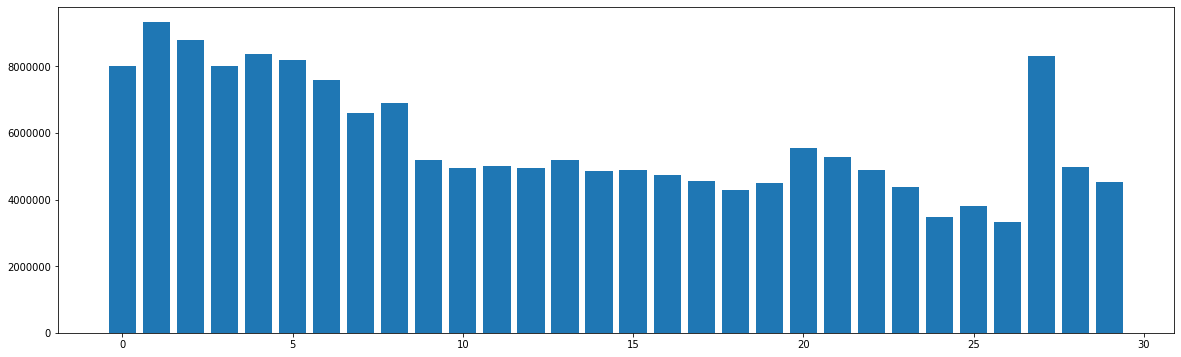

In [24]:
# Определить центральную область.
rc=df[df.locality_name=='Санкт-Петербург'].groupby('cityCenters_km')['last_price'].median()
fig, ax = plt.subplots()
ax.bar(rc.index,height=rc)
fig.set_figwidth(20)  
fig.set_figheight(6)
plt.show()

Имеем падение средней цены на 8 км. Значит будем считать, что центральная область это 8 км от центра.

Анализ распределения площади квартир центрального района
count    3315.000000
mean       72.568863
std        27.564223
min        12.000000
25%        50.400000
50%        69.400000
75%        90.650000
max       150.000000
Name: total_area, dtype: float64


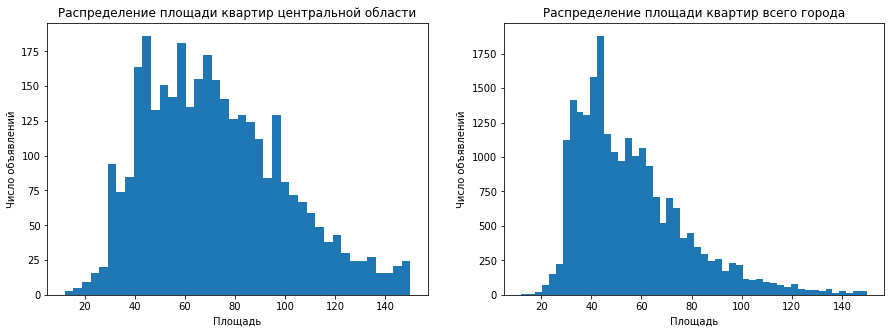

In [25]:
# отображаем данные для анализа
testdf=df[(df.locality_name=='Санкт-Петербург') & (df.cityCenters_km<=8)]
print('Анализ распределения площади квартир центрального района')
print(testdf.total_area.describe())
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.hist(testdf.total_area,bins=40)
ax1.set_title('Распределение площади квартир центральной области')
ax1.set_xlabel('Площадь')
ax1.set_ylabel('Число объявлений')
ax2.hist(df.total_area,bins=50)
ax2.set_title('Распределение площади квартир всего города')
ax2.set_xlabel('Площадь')
ax2.set_ylabel('Число объявлений')
plt.show()

Анализ распределения цен квартир центрального района
count        3315.00000
mean      8547029.79216
std       3514178.85777
min       1600000.00000
25%       5970000.00000
50%       7930000.00000
75%      10500000.00000
max      20000000.00000
Name: last_price, dtype: object


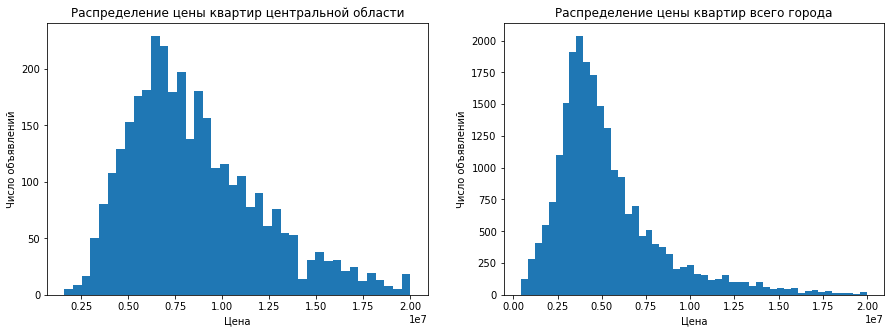

In [26]:
print('Анализ распределения цен квартир центрального района')
print(testdf.last_price.describe().apply("{0:.5f}".format))
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.hist(testdf.last_price,bins=40)
ax1.set_title('Распределение цены квартир центральной области')
ax1.set_xlabel('Цена')
ax1.set_ylabel('Число объявлений')
ax2.hist(df.last_price,bins=50)
ax2.set_title('Распределение цены квартир всего города')
ax2.set_xlabel('Цена')
ax2.set_ylabel('Число объявлений')
plt.show()

Анализ распределения комнат квартир центрального района
count    3315.000000
mean        2.477828
std         1.067589
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: rooms, dtype: float64


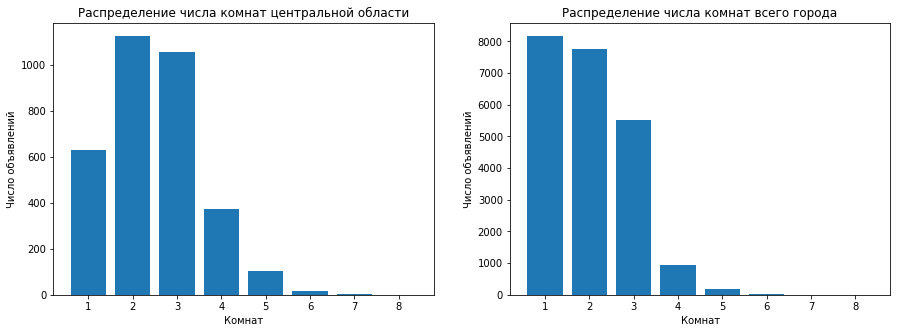

In [27]:
print('Анализ распределения комнат квартир центрального района')
print(testdf.rooms.describe())
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
rc=testdf.groupby('rooms')['rooms'].count()
ax1.bar(rc.index,height=rc)
ax1.set_title('Распределение числа комнат центральной области')
ax1.set_xlabel('Комнат')
ax1.set_ylabel('Число объявлений')
rc1=df.groupby('rooms')['rooms'].count()
ax2.bar(rc1.index,height=rc1)
ax2.set_title('Распределение числа комнат всего города')
ax2.set_xlabel('Комнат')
ax2.set_ylabel('Число объявлений')
plt.show()

Анализ распределения высоты потолков квартир центрального района
count    3315.000000
mean        2.900615
std         0.308493
min         2.400000
25%         2.700000
50%         2.750000
75%         3.060000
max         4.000000
Name: ceiling_height, dtype: float64


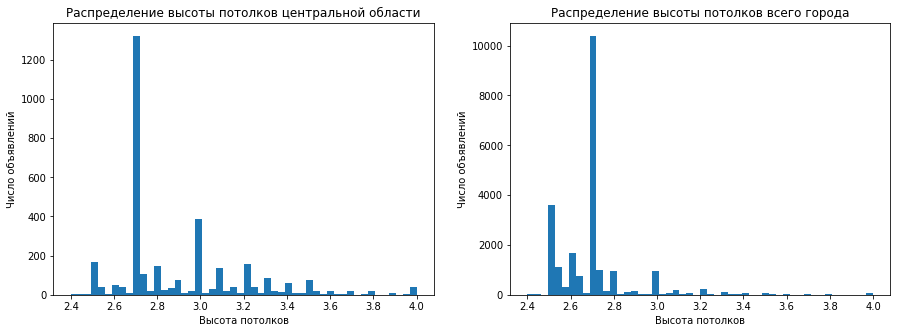

In [28]:
print('Анализ распределения высоты потолков квартир центрального района')
print(testdf.ceiling_height.describe())
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.hist(testdf.ceiling_height,bins=50)
ax1.set_title('Распределение высоты потолков центральной области')
ax1.set_xlabel('Высота потолков')
ax1.set_ylabel('Число объявлений')
ax2.hist(df.ceiling_height,bins=50)
ax2.set_title('Распределение высоты потолков всего города')
ax2.set_xlabel('Высота потолков')
ax2.set_ylabel('Число объявлений')
plt.show()

Анализ Зависимость цены от количества комнат для центрального района


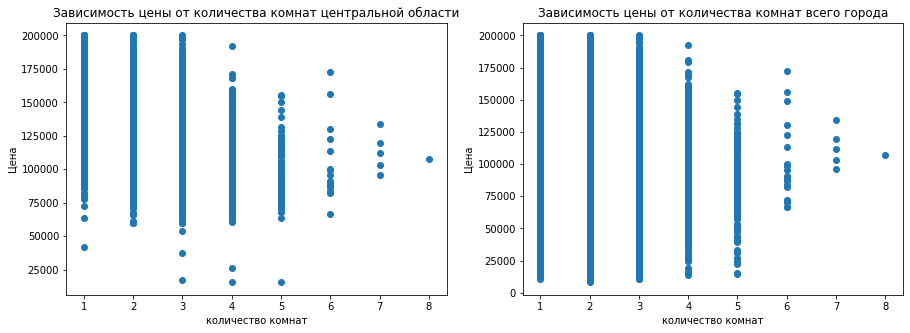

In [29]:
print('Анализ Зависимость цены от количества комнат для центрального района')
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.scatter(x=testdf.rooms,y=testdf.metr_price)
ax1.set_title('Зависимость цены от количества комнат центральной области')
ax1.set_xlabel('количество комнат')
ax1.set_ylabel('Цена')
ax2.scatter(x=df.rooms,y=df.metr_price)
ax2.set_title('Зависимость цены от количества комнат всего города')
ax2.set_xlabel('количество комнат')
ax2.set_ylabel('Цена')
plt.show()

Анализ Зависимость цены от этажа для центрального района


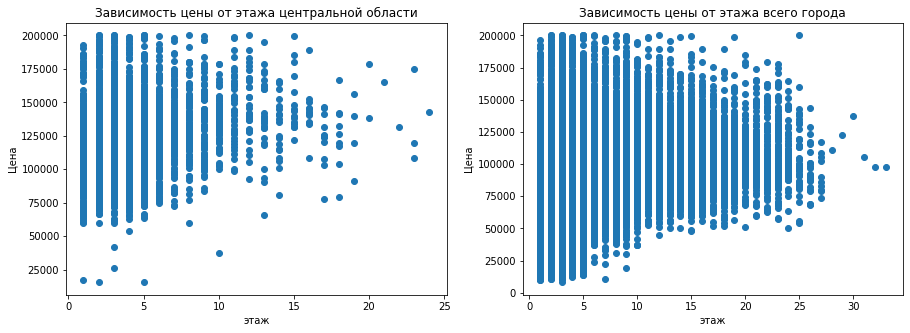

In [30]:
# этаж
print('Анализ Зависимость цены от этажа для центрального района')
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.scatter(x=testdf.floor,y=testdf.metr_price)
ax1.set_title('Зависимость цены от этажа центральной области')
ax1.set_xlabel('этаж')
ax1.set_ylabel('Цена')
ax2.scatter(x=df.floor,y=df.metr_price)
ax2.set_title('Зависимость цены от этажа всего города')
ax2.set_xlabel('этаж')
ax2.set_ylabel('Цена')
plt.show()

Анализ Зависимость цены от даты размещения для центрального района


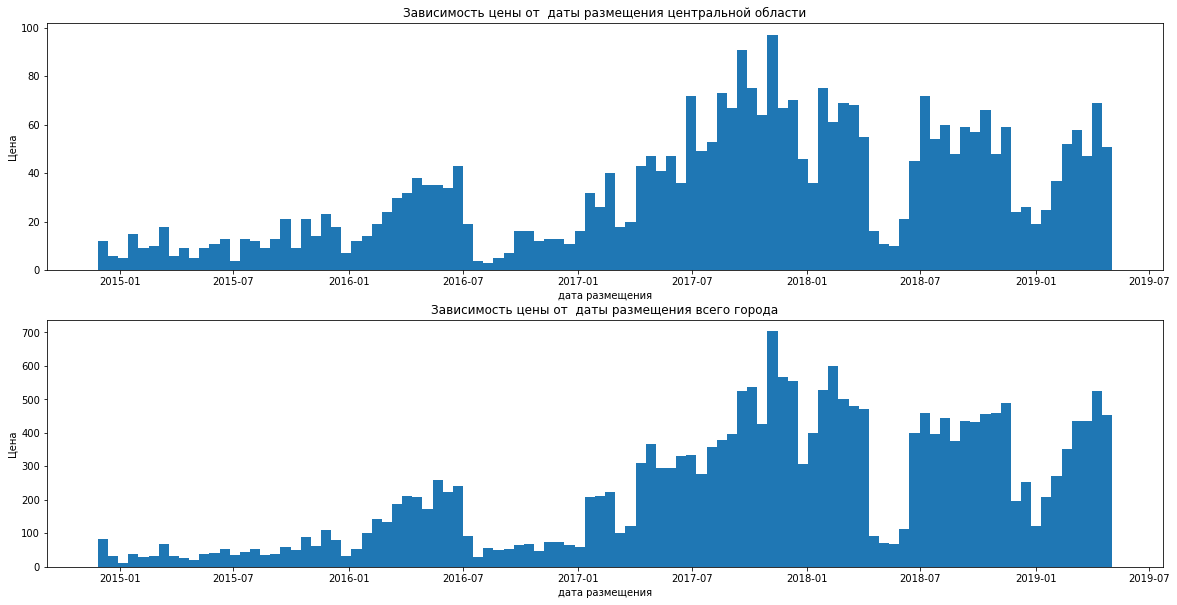

In [31]:
# дата
print('Анализ Зависимость цены от даты размещения для центрального района')
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax1.hist(testdf.first_day_exposition,bins=100)
ax1.set_title('Зависимость цены от  даты размещения центральной области')
ax1.set_xlabel('дата размещения')
ax1.set_ylabel('Цена')
ax2.hist(df.first_day_exposition,bins=100)
ax2.set_title('Зависимость цены от  даты размещения всего города')
ax2.set_xlabel('дата размещения')
ax2.set_ylabel('Цена')
plt.show()

Анализ Зависимость цены от удаленности от центра для центрального района


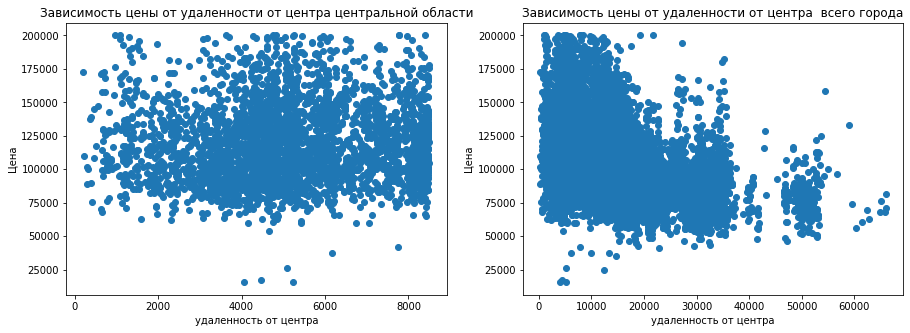

In [32]:
# удаленность
print('Анализ Зависимость цены от удаленности от центра для центрального района')
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.scatter(x=testdf.cityCenters_nearest,y=testdf.metr_price)
ax1.set_title('Зависимость цены от удаленности от центра центральной области')
ax1.set_xlabel('удаленность от центра')
ax1.set_ylabel('Цена')
ax2.scatter(x=df.cityCenters_nearest,y=df.metr_price)
ax2.set_title('Зависимость цены от удаленности от центра  всего города')
ax2.set_xlabel('удаленность от центра')
ax2.set_ylabel('Цена')
plt.show()

### вывод

   В целом распределение параметров площади, количества комнат и высоты потолков квартир центрального округа соответствуют общему распределению. Но есть и нюансы.
      Отличается средняя площадь. По городу она составляет 60 кв.м., в центре 72,3кв.м. На диаграмме распределения площади можно увидеть достаточно широкое распределение от 40 до 80, в то время как в целом по всем объявлениям узкий пик в районе 50кв.м.
   Существенно отличается цена. Если в целом по городу среднее 5,6млн, то для центрального округа среднее 8.5 млн. 
   Распределение числа комнат соответствует общему. Большой пик в части однокомнатных квартир в общем распределении объясняется заменой пустых значений в этом столбце на 1.
   В распределении высоты потолков для центральной области имеется существенный пик квартир с высотой потолков 3м.
   
   В части зависимости цены от числа комнат, этажа, даты размещения и удаленности от центра, мы видим, что в целом эти зависимости соответствуют зависимостям по всему набору данных, естественно с учетом масштаба. Т.к. в выборке центральной области существенно меньше объявлений, то и в зависимостях становиться меньше крайних значений и распределения выглядят более равномерными.

   

## Общий вывод

   Как показало наше исследование, у объекта недвижимости есть два основных параметра: площадь и близость от центра. Именно по этим параметрам имеется заметна корреляция с ценой. Все остальные параметры играют роль вспомогательных и не являются определяющими, хотя и влияющими на цену.
   
   Этажность оказывает влияние в случае первого и последнего этажа, они немного дешевле.
   
   Исходя из наших данных, для Санкт-Петербурга центральной областью можно считать удаленность от центра до 8 км включительно. Именно в этой области наблюдается существенное (около 20%) повышение средней цены.
   
   Так же можно сказать, что цена имеет очень большой разброс, слабо связанный с каким либо конкретным параметром. Это означает, что разброс цены на объекты одинаковой площади может достигать двух раз. Такое поведение может быть объяснено тем, что в наших данных нехватает характеристик. Например таких как год постройки дома, состояние дома, внутреннее состояние помещения, есть ремон или нет, продаестя с мебелью и техникой или нет. Ну и такие немаловажные параметры как ширина дворовых проездов и будет ли где поставить машину вечером.